In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num , DateFormatter
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


from src.globals import raw_data_dir, interim_data_dir
from src.visualization import plot_metrics

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [4]:
# check GPU visibility
tf.config.get_visible_devices(
    device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
from src.helpers import WindowGenerator

In [17]:
w1 = WindowGenerator(input_width=24, label_width=6, shift=6,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=['Lufttemperatur [GradC]'],
                     embedding_column='Location')
w1

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29]
Label column name(s): ['Lufttemperatur [GradC]']

In [29]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

print(f'Window shape: {example_window.shape}')

Window shape: (3, 30, 12)


In [30]:
example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs[0].shape}')
print(f'Embedding-Inputs shape: {example_inputs[1].shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 30, 12)
Inputs shape: (3, 24, 11)
Embedding-Inputs shape: (3, 24)
labels shape: (3, 6, 1)


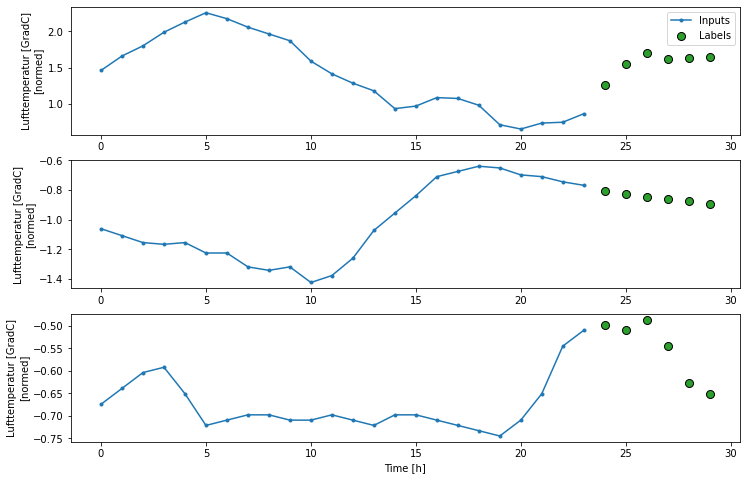

In [28]:
w1.plot()

In [27]:
w1.train

<MapDataset shapes: (((None, 24, 11), (None, 24)), (None, 6, 1)), types: ((tf.float32, tf.float32), tf.float32)>

In [21]:
max(train_df.Location)

3

In [25]:
tf.keras.backend.clear_session()

# Node Embeddings
embedding_inputs = tf.keras.Input(shape =(24,))
embedding_layer = tf.keras.layers.Embedding(input_dim=max(train_df.Location) + 1, 
                                            output_dim=2, input_length=24)(embedding_inputs)

# Encoder Inputs
feature_inputs = tf.keras.layers.Input(shape=(24, 11))

# Concat Embeddings & Encoder Inputs
concat_layer = tf.keras.layers.Concatenate()([feature_inputs, embedding_layer])

layer1 = tf.keras.layers.LSTM(30, return_sequences=True)(concat_layer)

output = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(units=6, activation='linear'))

output = output(layer1)

model = tf.keras.Model(inputs=[feature_inputs, embedding_inputs], outputs=output)

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported